> # Neural Network Basic - Week3 과제


## Import Library

In [93]:
import numpy as np
from matplotlib import pyplot as plt
from dataset.mnist import load_mnist
from tqdm import tqdm

## Load Dataset
- MNIST 

In [3]:
(X_train, Y_train), (X_test, Y_test) = load_mnist(normalize=True, one_hot_label=False)

In [4]:
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'Y_train shape: {Y_train.shape}')
print(f'Y_train shape: {Y_test.shape}')

X_train shape: (60000, 784)
X_test shape: (10000, 784)
Y_train shape: (60000,)
Y_train shape: (10000,)


## Activation Function 
- sigmoid & relu : hidden layer activation function 
- softmax : output layer activation function 

In [48]:
class sigmoid:
    # sigmoid 함수를 작성하세요 
    def forward(x):
        y = 1/(1+np.exp(-x))
        return y 
    
    # sigmoid 함수의 미분을 작성하세요
    def backward(x):
        y = (1/(1+np.exp(-x))) * (1 - (1/(1+np.exp(-x))))
        return y

In [24]:
class relu:
    # relu 함수를 작성하세요
    def forward(x):
        y = x if x>0 else 0
        return y
    
    # relu 함수의 미분을 작성하세요
    def backward(x):
        y = 1 if x>0 else 0
        return y

In [25]:
class softmax:
    def forward(z):
        y = []
        for zi in z:
            c = np.max(zi)
            exp_zi = np.exp(zi-c)
            sum_exp_zi = np.sum(exp_zi)
            yi = exp_zi / sum_exp_zi
            y.append(yi)

        return np.array(y)
    
    def backward(p, y) :
        dp = p.copy()
        for dpi, yi in zip(dp, y):
            for k in range(dp.shape[1]):
                if k == yi :
                    dpi[k] -= 1
        return dp

## Loss Function

In [26]:
def cross_entropy(p, y):
    loss = []
    for pi, yi in zip(p, y):
        for k in range(p.shape[1]):
            if k == yi:
                loss.append((-1) * (np.log(pi[k] + 1e-8))) 
    return loss

## Layer

In [27]:
class Layer:
    def __init__(self, input_size, output_size, std=1e-4) :
        self.input_size = input_size
        self.output_size = output_size
        self.bias = np.random.randn(output_size)
        self.weight = np.random.randn(input_size, output_size)*std

## Neural Network
- 각 메소드와 변수들의 역할을 주석으로 달아주세요! 

In [121]:
class CustomNet:
    # CustomNet을 선언할 때 생성되는 값들입니다.
    def __init__(self, lr=0.0001, epoch=500, batch_size=200):
        self.lr = lr                           # 학습률
        self.epoch = epoch                     # 에폭 수
        self.batch_size = batch_size           # 배치 사이즈
        self.loss_function = cross_entropy     # 손실 함수
        self.layers = []                       # 전체 레이어
        self.activations = [softmax]           # 활성화 함수
        self.nodes = []                        # 각 레이어의 노드
    
    # Layer를 추가할 때 호출합니다
    def addLayer(self, Layer): 
        self.layers.append(Layer) 
        if not self.nodes: 
            self.nodes.append(np.zeros(Layer.input_size))
        self.nodes.append(np.zeros(Layer.output_size))
        
    # Activation Function을 추가할 때 호출합니다
    def addActivation(self, Activation):
        tmp = self.activations.pop() 
        self.activations.append(Activation) 
        self.activations.append(tmp) 
        
    # 순전파 함수
    def _forward(self, X):
        self.nodes[0] = X.copy() 
        output = X.copy() 
        for i in range(len(self.layers)): 
            Layer = self.layers[i] 
            Activation = self.activations[i] 
            output = np.dot(self.nodes[i], Layer.weight)    # 이전 노드값과 가중치 dot product
            output = output+ Layer.bias                     # 위의 값에 bias 더함
            output = Activation.forward(output)             # 활성화 함수 호출
            self.nodes[i+1] = output                        # 출력값을 다음 레이어 노드값에 넣음
        return output   
    
    # 역전파 함수
    def _backward(self, X, output, y) :
        for i in reversed(range(len(self.layers))): 
            a = self.nodes[i+1] 
            Layer = self.layers[i] 
            Activation = self.activations[i] 
            
            if i+1 == len(self.layers): 
                error = Activation.backward(output, y)
            else:
                error *= Activation.backward(a)
            Layer.weight -= np.dot(error.T, self.nodes[i]).T*self.lr/X.shape[0] 
            Layer.bias -= error.sum(axis=0)*self.lr/X.shape[0]
            error = np.dot(error, Layer.weight.T) 
            
    # Accrucy를 반환합니다
    def _accuracy(self, output, y):
        pre_p = np.argmax(output, axis=1)
        return np.sum(pre_p==y)/y.shape[0] 
    
    # 데이터셋에 모델을 fit할때 호출합니다
    def fit(self, X, y, val_X, val_y):
        history = {'val_acc': [],'val_loss': []}
        N = X.shape[0]
        for i in tqdm(range(self.epoch)):
            for j in range(N//self.batch_size): 
                batch_mask = np.random.choice(N, self.batch_size)
                X_batch = X[batch_mask] 
                y_batch = y[batch_mask] 
                output = self._forward(X_batch) 
                self._backward(X_batch, output, y_batch)
            
            #accuracy와 loss를 기록해둡시다
            output = self._forward(val_X) 
            history["val_acc"].append(self._accuracy(output, val_y)) 
            history["val_loss"].append(sum(self.loss_function(output, val_y))) 
            
            #중간중간 기록을 찍어볼 때 사용. 적절히 조절해 쓰세요
            if i % 10 == 0:
                print(i, "test accuracy :", history["val_acc"][-1])
                print(i, "test loss     :", history["val_loss"][-1])
        return history

# 시도 1

## Customizing
- Network parameter, Layer architecture, Activation function .. 등등 다양한 하이퍼파라미터를 커스터마이징하여 높은 성능에 도달해 봅시다! 

In [49]:
# 하이퍼파라미터를 적절히 조절해 뉴럴넷을 선언하세요
nn = CustomNet(lr=0.005, epoch=200, batch_size=400)

# 원하는 만큼 층과 활성화 함수를 쌓아 주세요. 기본적으로 2Layer를 예시로 적어드립니다
nn.addLayer(Layer(784,100))
nn.addActivation(sigmoid)
nn.addLayer(Layer(100,10))

In [50]:
# 선언한 뉴럴넷의 구조입니다
for layer in nn.layers:
    print(layer.weight.shape, layer.bias.shape)

(784, 100) (100,)
(100, 10) (10,)


In [51]:
history = nn.fit(X_train, Y_train, X_test, Y_test)

0 test accuracy : 0.1135
0 test loss     : 23032.21637965088
10 test accuracy : 0.1135
10 test loss     : 22965.639124362424
20 test accuracy : 0.1239
20 test loss     : 22904.46951083838
30 test accuracy : 0.1751
30 test loss     : 22797.9808967081
40 test accuracy : 0.2316
40 test loss     : 22489.70433581282
50 test accuracy : 0.2636
50 test loss     : 21569.65288020852
60 test accuracy : 0.2748
60 test loss     : 19909.245612378745
70 test accuracy : 0.3769
70 test loss     : 18237.032847421626
80 test accuracy : 0.4328
80 test loss     : 16350.334725367924
90 test accuracy : 0.5036
90 test loss     : 14577.485636303627
100 test accuracy : 0.5934
100 test loss     : 13078.860725677505
110 test accuracy : 0.6566
110 test loss     : 11522.17450427391
120 test accuracy : 0.7037
120 test loss     : 10111.904452998955
130 test accuracy : 0.7375
130 test loss     : 9010.890713478519
140 test accuracy : 0.7682
140 test loss     : 8142.298658682795
150 test accuracy : 0.7937
150 test loss 

In [79]:
print(nn.nodes[0].shape, nn.nodes[1].shape, nn.nodes[2].shape, '\n')
for n in nn.nodes:
    print(n, '\n')

(10000, 784) (10000, 100) (10000, 10) 

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] 

[[0.12984232 0.24523528 0.0860366  ... 0.01690754 0.18506639 0.43121899]
 [0.28584474 0.13310417 0.42567795 ... 0.98184477 0.06372795 0.54106687]
 [0.22619284 0.23565133 0.07017003 ... 0.74482297 0.11394972 0.16024675]
 ...
 [0.42168056 0.33306651 0.07321983 ... 0.73109908 0.13214869 0.11093603]
 [0.24619394 0.18436642 0.15079568 ... 0.86735129 0.10897487 0.21493615]
 [0.63864501 0.10165242 0.9483563  ... 0.98043679 0.06050537 0.83118003]] 

[[7.94692636e-05 2.43956714e-04 3.84008857e-04 ... 9.34750255e-01
  4.21656089e-03 5.22997031e-02]
 [5.02136526e-02 3.58932654e-03 6.78956880e-01 ... 2.09660792e-07
  1.02084419e-02 9.48150403e-07]
 [3.05507206e-06 9.57347557e-01 1.25958932e-02 ... 3.85760334e-03
  8.36775792e-03 1.21221561e-03]
 ...
 [2.04307514e-05 2.63275310e-04 3.78121669e-04 ... 3.6

## Accuracy, Loss Visualization
- 자유롭게 Accuracy나 Loss를 시각화하여 확인하고 결과를 확인해 보세요! 

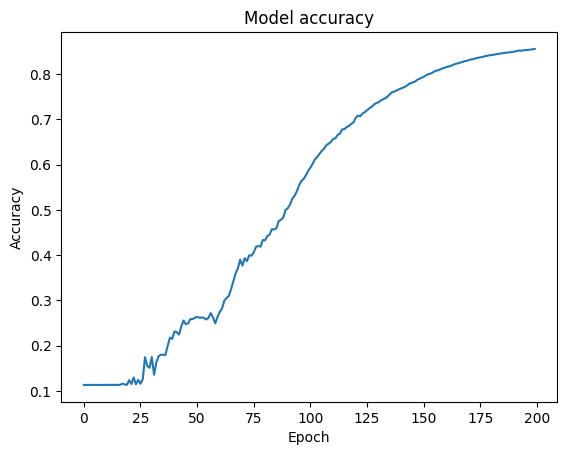

In [59]:
# 6 훈련 과정 시각화 (정확도)
plt.plot(history['val_acc'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

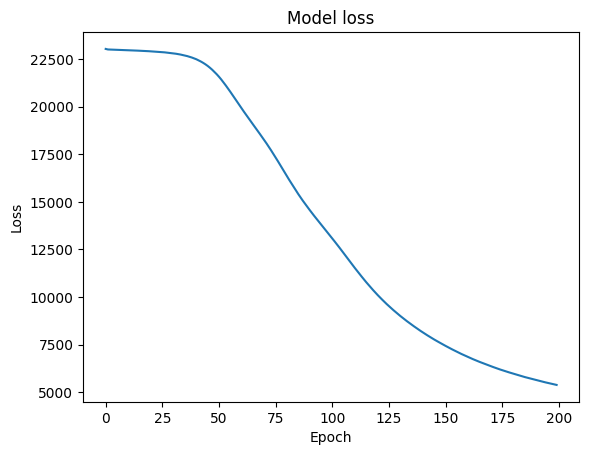

In [61]:
# 7 훈련 과정 시각화 (손실)
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# 시도 2

- 에폭 수 증가
- 시도 1에서 accuracy 개선 여지가 더 보이므로

In [83]:
# 하이퍼파라미터를 적절히 조절해 뉴럴넷을 선언하세요
nn = CustomNet(lr=0.005, epoch=300, batch_size=400)

# 원하는 만큼 층과 활성화 함수를 쌓아 주세요. 기본적으로 2Layer를 예시로 적어드립니다
nn.addLayer(Layer(784, 100))
nn.addActivation(sigmoid)
nn.addLayer(Layer(100,10))

In [84]:
# 선언한 뉴럴넷의 구조입니다
for layer in nn.layers:
    print(layer.weight.shape, layer.bias.shape)

(784, 100) (100,)
(100, 10) (10,)


In [85]:
history = nn.fit(X_train, Y_train, X_test, Y_test)

0 test accuracy : 0.101
0 test loss     : 23072.025115895547
10 test accuracy : 0.1459
10 test loss     : 22738.927964263825
20 test accuracy : 0.2055
20 test loss     : 22273.79618988777
30 test accuracy : 0.2215
30 test loss     : 21342.561019425426
40 test accuracy : 0.2348
40 test loss     : 20047.011699313018
50 test accuracy : 0.2732
50 test loss     : 19036.753305821345
60 test accuracy : 0.3622
60 test loss     : 18287.23982667349
70 test accuracy : 0.4054
70 test loss     : 17432.381547994613
80 test accuracy : 0.4567
80 test loss     : 16036.310546319855
90 test accuracy : 0.5243
90 test loss     : 14261.280068424829
100 test accuracy : 0.5949
100 test loss     : 12474.096399457207
110 test accuracy : 0.6538
110 test loss     : 10969.99176470452
120 test accuracy : 0.6932
120 test loss     : 9845.136955434387
130 test accuracy : 0.7261
130 test loss     : 9009.277637478412
140 test accuracy : 0.7498
140 test loss     : 8345.250340526865
150 test accuracy : 0.7673
150 test los

## Accuracy, Loss Visualization
- 자유롭게 Accuracy나 Loss를 시각화하여 확인하고 결과를 확인해 보세요! 

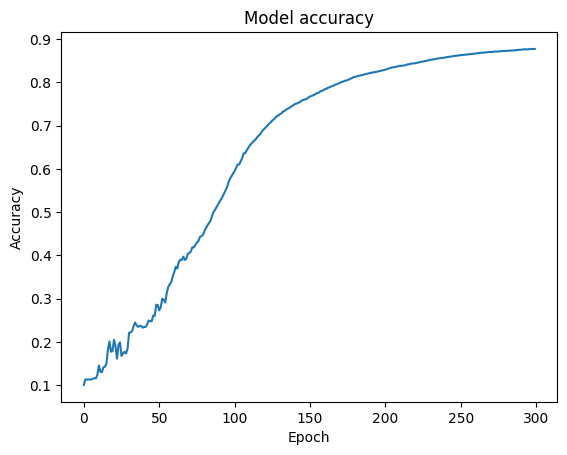

In [86]:
# 6 훈련 과정 시각화 (정확도)
plt.plot(history['val_acc'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

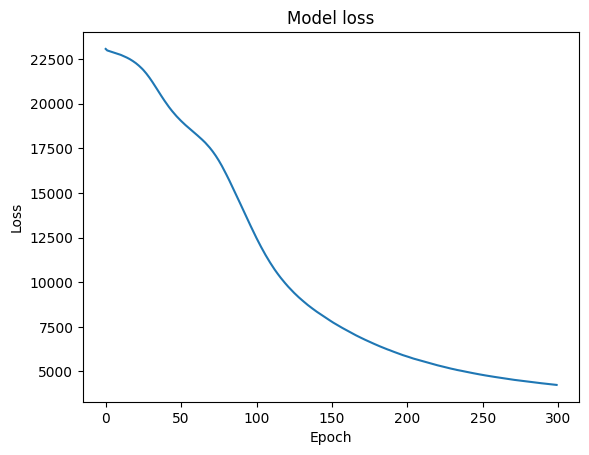

In [87]:
# 7 훈련 과정 시각화 (손실)
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# 시도 3

- 학습률증가
- 에폭 수를 늘렸으나 시도 2의 학습속도가 너무 느리다고 판단

In [106]:
# 하이퍼파라미터를 적절히 조절해 뉴럴넷을 선언하세요
nn = CustomNet(lr=0.01, epoch=200, batch_size=400)

# 원하는 만큼 층과 활성화 함수를 쌓아 주세요. 기본적으로 2Layer를 예시로 적어드립니다
nn.addLayer(Layer(784, 100))
nn.addActivation(sigmoid)
nn.addLayer(Layer(100,10))

In [107]:
# 선언한 뉴럴넷의 구조입니다
for layer in nn.layers:
    print(layer.weight.shape, layer.bias.shape)

(784, 100) (100,)
(100, 10) (10,)


In [109]:
history = nn.fit(X_train, Y_train, X_test, Y_test)

  0%|          | 1/200 [00:03<10:41,  3.22s/it]

0 test accuracy : 0.1135
0 test loss     : 23004.10126599715


  6%|▌         | 11/200 [00:46<14:14,  4.52s/it]

10 test accuracy : 0.1135
10 test loss     : 22878.96655371959


 10%|█         | 21/200 [01:28<12:19,  4.13s/it]

20 test accuracy : 0.177
20 test loss     : 22252.03591700674


 16%|█▌        | 31/200 [02:11<11:46,  4.18s/it]

30 test accuracy : 0.2977
30 test loss     : 19566.055423894257


 20%|██        | 41/200 [02:53<11:22,  4.29s/it]

40 test accuracy : 0.4643
40 test loss     : 16482.175001561052


 26%|██▌       | 51/200 [03:36<10:37,  4.28s/it]

50 test accuracy : 0.6067
50 test loss     : 12122.90454197288


 30%|███       | 61/200 [04:19<10:00,  4.32s/it]

60 test accuracy : 0.6906
60 test loss     : 9695.89590932893


 36%|███▌      | 71/200 [05:04<10:13,  4.76s/it]

70 test accuracy : 0.7542
70 test loss     : 8151.353333867683


 40%|████      | 81/200 [05:46<08:06,  4.09s/it]

80 test accuracy : 0.8004
80 test loss     : 6967.362935790058


 46%|████▌     | 91/200 [06:31<08:17,  4.56s/it]

90 test accuracy : 0.8312
90 test loss     : 6099.00030058369


 50%|█████     | 101/200 [07:16<07:29,  4.54s/it]

100 test accuracy : 0.8505
100 test loss     : 5465.771670251358


 56%|█████▌    | 111/200 [07:58<06:15,  4.22s/it]

110 test accuracy : 0.8632
110 test loss     : 4994.562183496021


 60%|██████    | 121/200 [08:39<05:18,  4.04s/it]

120 test accuracy : 0.8745
120 test loss     : 4633.037263003206


 66%|██████▌   | 131/200 [09:21<04:54,  4.26s/it]

130 test accuracy : 0.8816
130 test loss     : 4352.316764184079


 70%|███████   | 141/200 [10:04<04:09,  4.23s/it]

140 test accuracy : 0.8861
140 test loss     : 4128.810473702385


 76%|███████▌  | 151/200 [10:48<03:18,  4.06s/it]

150 test accuracy : 0.8898
150 test loss     : 3949.594056774676


 80%|████████  | 161/200 [11:31<02:55,  4.51s/it]

160 test accuracy : 0.8928
160 test loss     : 3801.4969707816063


 86%|████████▌ | 171/200 [12:14<02:08,  4.45s/it]

170 test accuracy : 0.8953
170 test loss     : 3681.7558265325224


 90%|█████████ | 181/200 [12:59<01:26,  4.55s/it]

180 test accuracy : 0.8974
180 test loss     : 3578.7800352628456


 96%|█████████▌| 191/200 [13:45<00:39,  4.42s/it]

190 test accuracy : 0.8994
190 test loss     : 3488.6712856670542


100%|██████████| 200/200 [14:27<00:00,  4.34s/it]


## Accuracy, Loss Visualization
- 자유롭게 Accuracy나 Loss를 시각화하여 확인하고 결과를 확인해 보세요! 

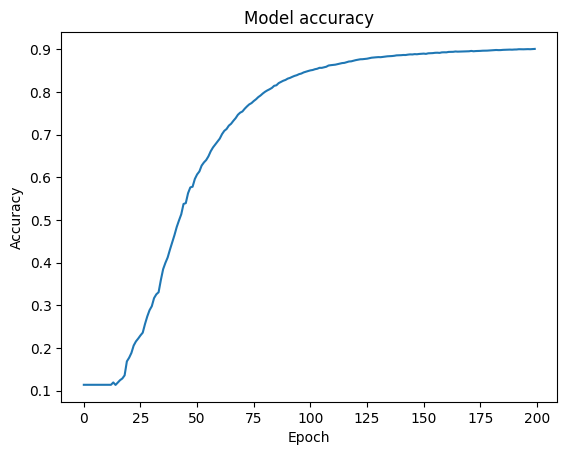

In [110]:
# 6 훈련 과정 시각화 (정확도)
plt.plot(history['val_acc'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

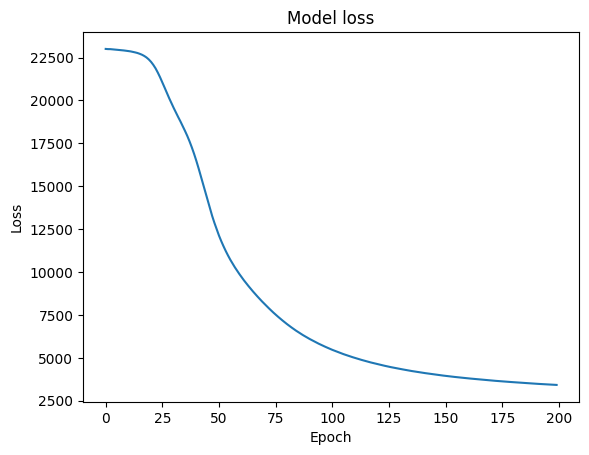

In [111]:
# 7 훈련 과정 시각화 (손실)
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# 시도 4

- 학습률증가
- 학습률증가로 인해 에폭 수를 줄여봄

In [122]:
# 하이퍼파라미터를 적절히 조절해 뉴럴넷을 선언하세요
nn = CustomNet(lr=0.05, epoch=100, batch_size=400)

# 원하는 만큼 층과 활성화 함수를 쌓아 주세요. 기본적으로 2Layer를 예시로 적어드립니다
nn.addLayer(Layer(784, 100))
nn.addActivation(sigmoid)
nn.addLayer(Layer(100,10))

In [123]:
# 선언한 뉴럴넷의 구조입니다
for layer in nn.layers:
    print(layer.weight.shape, layer.bias.shape)

(784, 100) (100,)
(100, 10) (10,)


In [124]:
history = nn.fit(X_train, Y_train, X_test, Y_test)

  1%|          | 1/100 [00:04<07:42,  4.67s/it]

0 test accuracy : 0.1009
0 test loss     : 22865.5861351706


 11%|█         | 11/100 [00:50<06:30,  4.38s/it]

10 test accuracy : 0.6535
10 test loss     : 10978.222940741793


 21%|██        | 21/100 [01:37<06:12,  4.71s/it]

20 test accuracy : 0.8515
20 test loss     : 5350.47926681841


 31%|███       | 31/100 [02:27<05:34,  4.84s/it]

30 test accuracy : 0.887
30 test loss     : 4001.2092934676534


 41%|████      | 41/100 [03:26<05:54,  6.01s/it]

40 test accuracy : 0.901
40 test loss     : 3492.5470035649255


 51%|█████     | 51/100 [04:17<03:44,  4.59s/it]

50 test accuracy : 0.9079
50 test loss     : 3229.8766533196667


 61%|██████    | 61/100 [05:00<02:48,  4.32s/it]

60 test accuracy : 0.9115
60 test loss     : 3064.9109233380327


 71%|███████   | 71/100 [05:46<02:14,  4.62s/it]

70 test accuracy : 0.9151
70 test loss     : 2959.893051690067


 81%|████████  | 81/100 [06:33<01:35,  5.04s/it]

80 test accuracy : 0.9175
80 test loss     : 2872.194047352672


 91%|█████████ | 91/100 [07:24<00:44,  4.92s/it]

90 test accuracy : 0.9192
90 test loss     : 2814.5892554895995


100%|██████████| 100/100 [08:08<00:00,  4.89s/it]


In [128]:
# 최종 accuracy
history['val_acc'][-1]

0.9204

## Accuracy, Loss Visualization
- 자유롭게 Accuracy나 Loss를 시각화하여 확인하고 결과를 확인해 보세요! 

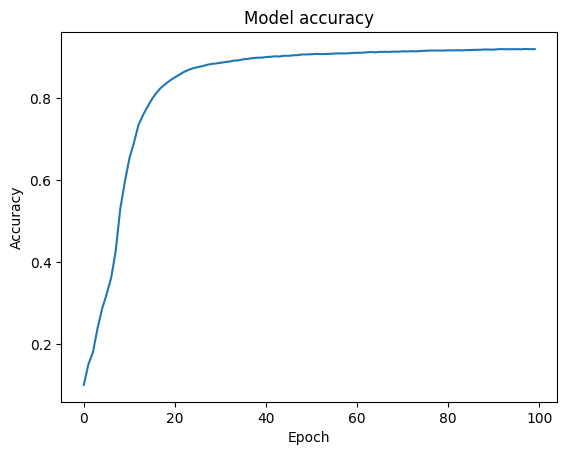

In [125]:
# 6 훈련 과정 시각화 (정확도)
plt.plot(history['val_acc'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

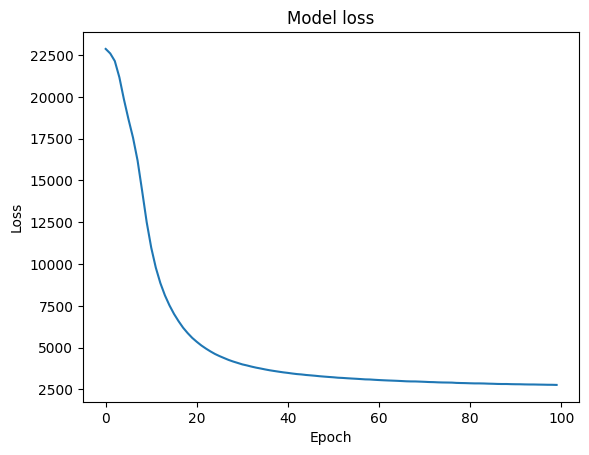

In [126]:
# 7 훈련 과정 시각화 (손실)
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.legend(['Train', 'Test'], loc='upper left')
plt.show()